In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy import stats
from yellowbrick.regressor import ResidualsPlot, PredictionError

## Read in Pickle

In [2]:
cleaned_KC = pd.read_pickle('./data/cleaned_KC.pkl')

# Scale price feature through logarithmic transformations

In [3]:
cleaned_KC.price = cleaned_KC.price.map(lambda x: np.log(x))

### Convert Features to Categorical

Because some of our features are categorical, we want to ensure they are of the appropriate data type; allowing us perform the appropriate functions on them.

In [4]:
categorical_features = ['bathrooms','bedrooms','zipcode','yr_built','grade','condition','view','floors']

In [5]:
# converts all categorical features to a categorical type
for feature in categorical_features:
    cleaned_KC[feature] = cleaned_KC[feature].astype('category')
cleaned_KC.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18825 entries, 0 to 19005
Data columns (total 15 columns):
id               18825 non-null int64
date             18825 non-null object
price            18825 non-null float64
bedrooms         18825 non-null category
bathrooms        18825 non-null category
sqft_living      18825 non-null int64
sqft_lot         18825 non-null int64
floors           18825 non-null category
view             18825 non-null category
condition        18825 non-null category
grade            18825 non-null category
yr_built         18825 non-null category
zipcode          18825 non-null category
sqft_living15    18825 non-null int64
sqft_lot15       18825 non-null int64
dtypes: category(8), float64(1), int64(5), object(1)
memory usage: 1.3+ MB


# Check for Linear Relationship

### Calculate Pearson's R Value
Pearson's R represents a correlation coefficient. So a Pearson's R > .5  means there is a positive correlation between the feature. We can see that both ```sqft_living``` and ```sqft_living15``` show a positive correlation.

In [6]:
cleaned_KC.corr()['price'].sort_values(ascending=False)

price            1.000000
sqft_living      0.572739
sqft_living15    0.516397
sqft_lot         0.074291
sqft_lot15       0.069154
id               0.025701
Name: price, dtype: float64

# Check for Multicollinearity

### Calculate VIF

The variance inflation factor is the quotient of the variance in a model with multiple terms by the variance of a model with one term alone.
It quantifies the severity of multicollinearity in an ordinary least squares regression analysis. 
It provides an index that measures how much the variance (the square of the estimate's standard deviation) of an estimated regression coefficient is increased because of collinearity.

In [7]:
# select only columns with datatype int64 or float 64
numeric_cleaned_KC = cleaned_KC.select_dtypes(include=['int64','float64']).drop(axis=1, columns=['id', 'price'])

vif = pd.DataFrame()

# For each column,run a variance_inflaction_factor against all other columns to get a VIF Factor score
vif["VIF Score"] = [variance_inflation_factor(numeric_cleaned_KC.values, i) for i in range(numeric_cleaned_KC.shape[1])]

# label the scores with their related columns
vif["features"] = numeric_cleaned_KC.columns

vif.round(1)

,VIF Score,features
0,18.5,sqft_living
1,2.3,sqft_lot
2,18.6,sqft_living15
3,2.5,sqft_lot15


If VIF > 5 there is an _indication_ that multicollinearity may be present; with VIF > 10 there is **certainly** multicollinearity among the variables.

Based on the first run of the VIF scores, ```Sqft_living``` and ```sqft_living15``` clearly have multi-collinearity, thus we will drop ```sqft_living15``` to reduce noise. 

In [8]:
# drop sqft_living15
numeric_cleaned_KC = numeric_cleaned_KC.drop(axis=1, columns=['sqft_living15'])

vif = pd.DataFrame()

# For each column,run a variance_inflaction_factor against all other columns to get a VIF Factor score
vif["VIF Score"] = [variance_inflation_factor(numeric_cleaned_KC.values, i) for i in range(numeric_cleaned_KC.shape[1])]

# label the scores with their related columns
vif["features"] = numeric_cleaned_KC.columns

vif.round(1)

,VIF Score,features
0,1.3,sqft_living
1,2.3,sqft_lot
2,2.5,sqft_lot15


# Linear Regression
Because our first two assumptions (Linear Relationship & No Multicollinearity) were met, we decided to run a basic Linear Regression.

### Calculate Regression Line of Price vs Sqft_living

In [9]:
# Transforms a dataframe into a np.array
X = cleaned_KC['sqft_living'].values.reshape(-1,1)
y = cleaned_KC['price'].values.reshape(-1,1)

# Create a Linear Regression object and fit a line using X and y
reg = LinearRegression()
reg.fit(X, y)

# using that line, make predictions for y using X
predictions = reg.predict(X)

### Plot Regression against Scatterplot

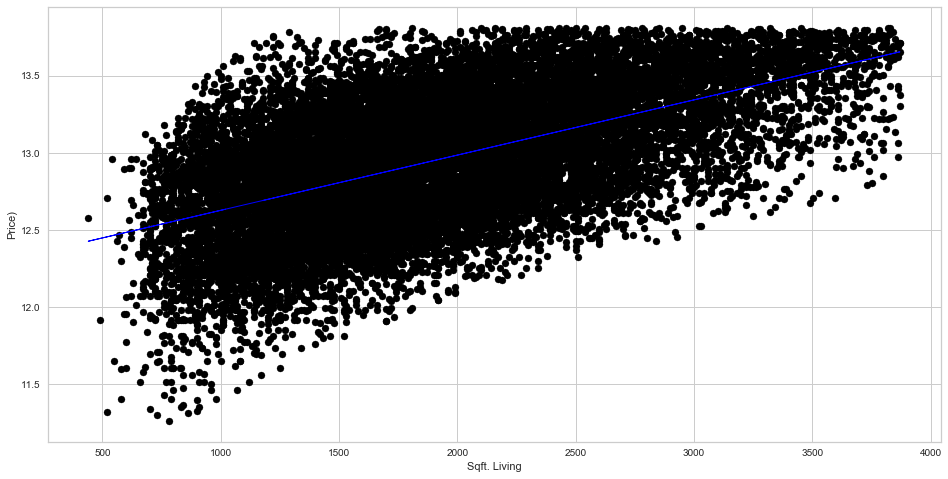

In [10]:
# Make a 16x8 figure that has...
plt.figure(figsize=(16, 8))

# ...a scatter plot of sqft_living vs price...
plt.scatter( X, y, c='black')

# ...plot the regression line...
plt.plot( X, predictions, c='blue', linewidth=1)

# ...set the labels and show
plt.xlabel("Sqft. Living")
plt.ylabel("Price)")
plt.show()

### Calculate OLS Regression Results

In [11]:
X = cleaned_KC['sqft_living'] # Set X to sqft_living values
y = cleaned_KC['price'] # Set y to price values
X2 = sm.add_constant(X) # add intercept column
est = sm.OLS(y, X2).fit() # Pass in X2 and y into Ordinary Least Square model
print(est.summary()) # Print out the report summary 

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.328
Method:                 Least Squares   F-statistic:                     9189.
Date:                Wed, 02 Oct 2019   Prob (F-statistic):               0.00
Time:                        15:18:12   Log-Likelihood:                -6903.9
No. Observations:               18825   AIC:                         1.381e+04
Df Residuals:                   18823   BIC:                         1.383e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.2696      0.008   1619.929      

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


## <span style="color:blue">Our Linear Regression R-Squared result:</span><span style="color:red"> .384 </span>

# Multiple Linear Regression w/ Categorical Variables

### Convert categorical features to dummy variables
Because some of our features are categorical, we'll want to transform them to dummy variables. Categorical features are not inheritly binary, because of that, we want to insert dummy-variable columns to create binary features that we can work with. 

In [12]:
categorial_columns = ['bathrooms','bedrooms','grade','view','floors']
non_categorial_columns = ['id','date','price','sqft_lot','condition','yr_built','zipcode','sqft_living15', 'sqft_lot15']

# This replaces categorical columns with dummy variables, and drops non categorical columns
dummies_df = pd.get_dummies(cleaned_KC, columns=categorial_columns).drop(columns=non_categorial_columns)

### Create X & Y Train/Test variables

In [13]:
# This sets X to a dataframe consisting of columns with dummy variables & without extra columns
X = dummies_df

# this simply sets y to the price column of the dataframe
y = cleaned_KC['price']

# This runs a train/test split with .20 of the data. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=40)

In [14]:
X.shape

(18825, 38)

### Calculate OLS

In [15]:
# Simply adding a y-intercept column.
X2 = sm.add_constant(X_train)

# Run an Ordinary Least Squares model using the array of y values, and the dataframe of x_train values and fit a line to it. 
est = sm.OLS(y_train, X2).fit()

# Checking Assumptions

### Residuals Plots - Checking Errors are normal
Before we compare which model best predicts our target, we want to ensure that our predicted errors are normally distributed. 

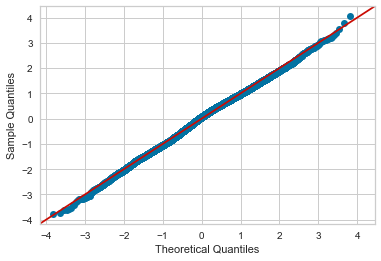

In [16]:
residuals = est.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)

Based on our QQ plot, we can conclude that our target variable **is** normally distributed.

### Homoscedasticity
We also want to test for Homescedasticity - meaning the residuals are equal across the regression line.

#### ScatterPlot the predicted values against the residuals

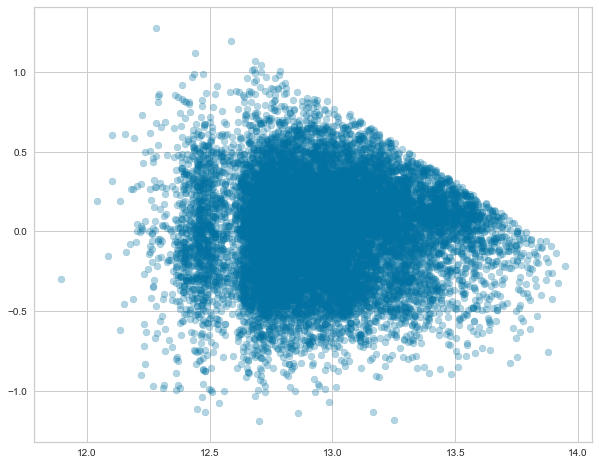

In [17]:
pred_val = est.fittedvalues.copy()
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(pred_val, residuals, alpha = 0.3)

#### Yellow Brick Residuals Plot

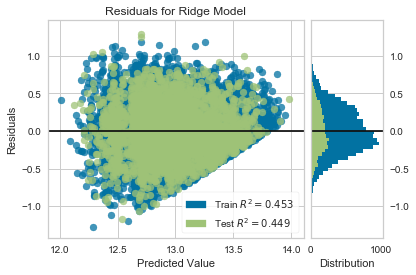

In [18]:
model = Ridge()
visualizer = ResidualsPlot(model)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()

Based on the results from our scatterplot of residuals, we can conclude that our residuals **are** normally distributed.

### Kurtosis, Skewness & Shapiro-Wilk tests

In [23]:
price_column = cleaned_KC.price

# Kurtosis test
print( 'excess kurtosis of normal distribution (should be 0): {}'.format( stats.kurtosis(price_column) ))

# Skewness test
print( 'skewness of normal distribution (should be 0): {}'.format( stats.skew(price_column) ))

excess kurtosis of normal distribution (should be 0): -0.2585759535427701
skewness of normal distribution (should be 0): -0.033513842993616295


## Results of Assumptions Tests

Based on the results of our assumptions testing, we can conclude that our residuals of our target variable are normally distributed. Thus, we can continue with our modeling to determine which one is best.

# Regression Models

## Linear Regression

In [33]:
# Creates a Linear Regression object
lin_reg = LinearRegression()

# Train the Regression object to fit a line with train data
lin_reg.fit(X_train, y_train)

# using that line, predict y values against x_test values.
y_pred = lin_reg.predict(X_test)

# Use sklearn.metrics.r2_score to determine r-squared based on y_test values and y_pred values.
r_squared = r2_score(y_test, y_pred).round(3)
r_squared

0.51

## Ridge Regression

In [34]:
ridge = Ridge()
alpha_values = [.001,.01,.1,1,10,100]
parameters = {'alpha': alpha_values}
ridge_regressor = GridSearchCV(ridge, parameters, scoring='r2', cv = 5)

ridge_regressor.fit(X_train,y_train)
ridge_squared = ridge_regressor.best_score_.round(3)
print(ridge_regressor.best_params_)
print(ridge_regressor.best_score_)

{'alpha': 0.001}
0.5175179884829139


## Lasso Regression

In [35]:
lasso = Lasso(max_iter=10000)
alpha_values = [.001,.01,.1,1,10,100]
parameters = {'alpha': alpha_values}
lasso_regressor = GridSearchCV(lasso, parameters, scoring='r2', cv = 5)

lasso_regressor.fit(X_train,y_train)

lasso_squared = lasso_regressor.best_score_.round(3)
print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)

{'alpha': 0.001}
0.5123777919449196


# Review Final Metrics

In [27]:
print("MSE: {}".format(mean_squared_error(y_test, y_pred).round(3)))
print("Linear Regression: {}".format(r_squared))
print("Ridge Regression: {}".format(ridge_squared))
print("Lasso Regression: {}".format(lasso_squared))

MSE: 0.102
Linear Regression: 0.51
Ridge Regression: 0.518
Lasso Regression: 0.512


Our MSE has **significantly** reduced from our previous MSE of 24956641900.831.

Based on the results of our Regression Models, we can conclude that the Ridge Regression model is more accurate than Linear and Lasso in predicting Prices of homes in King County.